In [31]:
#@title 1.1. Classes e funções
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
from packages.eRDF import butter_lowpass_filter,DataProcessor, read_discus_fit_file
from packages.eRDF import optimize_constant, calculate_rw

from PIL import Image
import hyperspy.api as hs
import cv2
from packages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration

from matplotlib import rcParams, cycler
from matplotlib.ticker import AutoMinorLocator


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 22
rcParams['axes.linewidth'] = 1.1
rcParams['axes.labelpad'] = 10.0
plot_color_cycle = cycler('color', ['000000', '0000FE', 'FE0000', '008001', 'FD8000', '8c564b', 
                                    'e377c2', '7f7f7f', 'bcbd22', '17becf'])
rcParams['axes.prop_cycle'] = plot_color_cycle
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams.update({"figure.figsize" : (6.4,4.8),
                 "figure.subplot.left" : 0.177, "figure.subplot.right" : 0.946,
                 "figure.subplot.bottom" : 0.156, "figure.subplot.top" : 0.965,
                 "axes.autolimit_mode" : "round_numbers",
                 "xtick.major.size"     : 7,
                 "xtick.minor.size"     : 3.5,
                 "xtick.major.width"    : 1.1,
                 "xtick.minor.width"    : 1.1,
                 "xtick.major.pad"      : 3,
                 "xtick.minor.visible" : True,
                 "ytick.major.size"     : 7,
                 "ytick.minor.size"     : 3.5,
                 "ytick.major.width"    : 1.1,
                 "ytick.minor.width"    : 1.1,
                 "ytick.major.pad"      : 5,
                 "ytick.minor.visible" : True,
                 "lines.markersize" : 10,
                 "lines.markerfacecolor" : "none",
                 "lines.markeredgewidth"  : 0.8})



In [ ]:
#masking polar image and comparing integration methods
import numpy.ma as ma
import pyFAI

mask = np.where(integrated_img > 0, 1, 0).astype(np.uint8)

integrated_img_processed = integrated_img.copy()
integrated_img_processed[mask == 0] = integrated_img.max()

plt.imshow(integrated_img_processed)
masked_image = ma.masked_equal(integrated_img, 0)
masked_image1 = ma.masked_equal(img+100, 0)

ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(2048, center_x, center_y)
res, intensity = ai.integrate1d(masked_image1, 3150, unit='2th_deg', correctSolidAngle=False,  azimuth_range=(-180, 180), method = "ocl_lut_integr")

plt.plot(integrated_img.mean(axis = 0), label = 'original')
plt.plot(masked_image.mean(axis = 0), label = 'masked')
plt.plot(intensity, label = 'original with PyFAI')
plt.legend()
plt.show()
#plt.xlim([1800, 4096])
#plt.ylim([0, 400])

In [32]:
#gold peak calibration
from scipy.signal import find_peaks

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Au/Au_28_may_24'

end_name = 'Au_end.csv'
start_name = 'Au_start.csv'

df1 = pd.read_csv(os.path.join(path, start_name), header = None)
df2 = pd.read_csv(os.path.join(path, end_name), header = None)

data_start = df1[0].values
data_end = df2[0].values

peaks_start, _ = find_peaks(data_start, distance = 40, height=500)
peaks_end, _ = find_peaks(data_end, distance = 40, height=500)



calibration_start = peak_calibration(pixel_positions = peaks_start[3:7])
calibration_end = peak_calibration(pixel_positions = peaks_end[1:5])

calibration = (calibration_start +calibration_end)/2

The calculated calibration factor ds: 0.007489631058762088
The calculated calibration factor ds: 0.007451840848228294


In [28]:
print(peaks_start[3:7])
print(peaks_end[1:5])

[356 409 583 685]
[358 411 587 687]


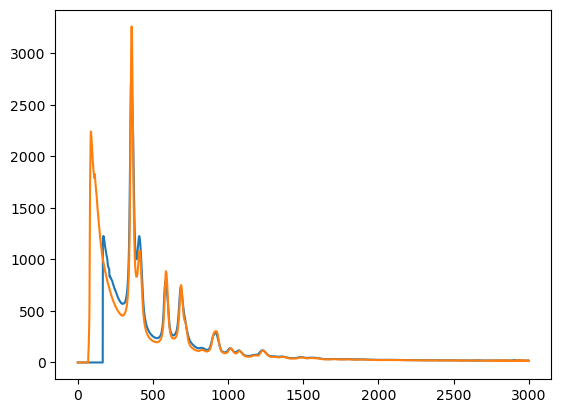

In [4]:
plt.plot(df1[0].values)
plt.plot(df2[0].values)

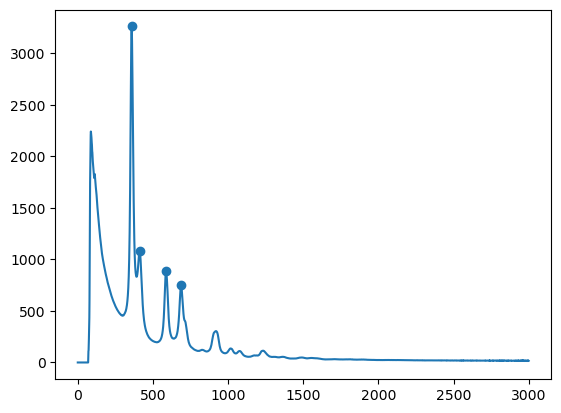

In [22]:

peaks_end, _ = find_peaks(data_end, distance = 1, height=500)

plt.plot(data_end)
plt.scatter(peaks_end[2:6], data_end[peaks_end[2:6]])

In [ ]:
#Conversion from pixel data to two-theta
wavelength = 1.5409

# Assuming 'data' index corresponds to 1/d values, you need to adjust how you calculate two_theta.
# Let's first convert indices to actual 1/d spacing if needed. This example assumes it directly corresponds.

# Correct calculation of two_theta from 1/d values
one_over_d = np.linspace(1, len(data), len(data))*(0.007584086757763026/(2*math.pi))  # This might need to be adjusted based on your actual d-spacing calculation
two_theta = 2 * np.degrees(np.arcsin(wavelength * (one_over_d) / 2))

plt.plot(two_theta, data, label="Intensity vs. 2θ")
plt.scatter(two_theta[peaks[1:5]], data[peaks[1:5]], color='red', label="Peaks")  # Highlighting peaks, ensure peaks are correctly mapped
plt.xlabel("2θ (degrees)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

print('The peaks found are 'f'{two_theta[peaks[1:5]]}')
# For the peak list, assuming 'peaks' correctly identifies indices in your q-space data

#with open(os.path.join(path, 'In2O3_peak_list.txt'), 'w') as arquivo:
#    for i in range(len(data)):  # Assuming 's' is meant to iterate over all data point
#          # Adjust this to match how you determine peaks in q-space
#        arquivo.write(f"{two_theta[i]}\t"f"{data[i]} \n")
        

In [ ]:
#remaking the number density line
path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/Gr'
file_path = os.path.join(path, 'Gr_nocut_Fe3O4_Oleyl-OH.grobs')

data = pd.read_csv(file_path, sep= '\t')
#data = read_discus_fit_file(file_path)
#s = np.arange(0, len(df.values)*(0.0011685*2*math.pi), 1/(0.0011685*250)*2*math.pi)

dr = round(50/len(data['gr'].values),4)
_r = np.arange(0, len(data['gr'].values)*dr, dr)
_Gr, _Gr_low_r = dp1.low_r_correction(data['gr'].values, nd*0.3, _r, r_cut = 1.59)
plt.plot(_r, _Gr)
plt.xlim(0,10)

#path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe3O4_classica/Stacked/'
#file_path = 'Gr_Fe3O4_classica_mean'
data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(file_path, sep='\t', float_format="%.10f", index='r')

6352.441226465268


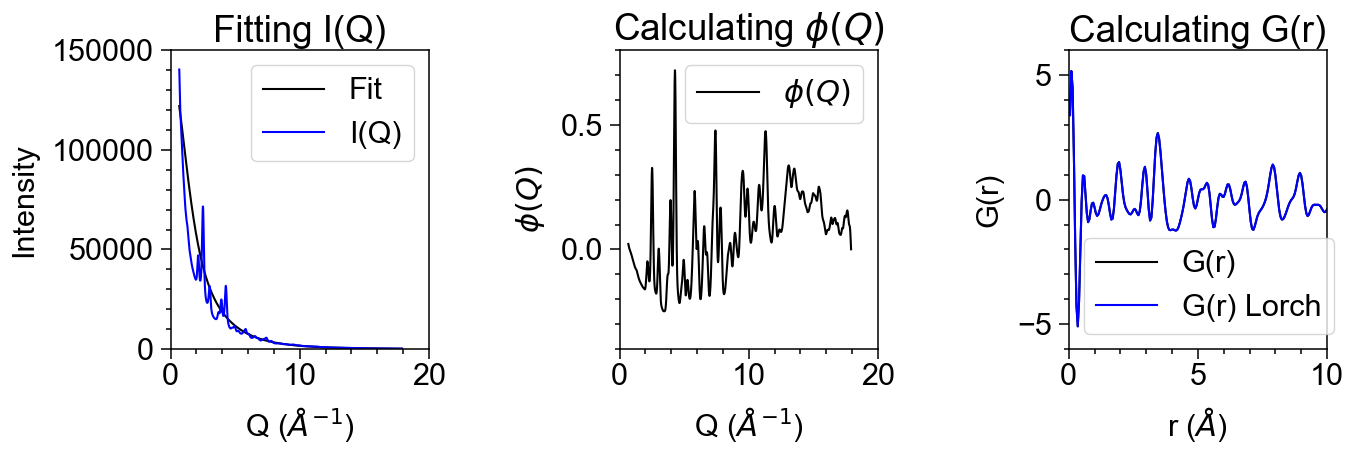

'\ndata = pd.DataFrame(np.transpose(np.array((_r, _Gr_Lorch))))\ndata.rename(columns={0:\'r\',1:\'gr\'},inplace=True)\ndata[\'dr\']=data[\'r\']*0\ndata[\'dgr\']=abs(data[\'gr\']/20)\ndata.to_csv(os.path.join(path, \'Gr_Lorch.csv\'), sep=\'\t\', float_format="%.10f", index=\'r\')\n\noutput_path = os.path.join(path, \'Gr_Lorch_filtered.csv\')\n\n# Filter the DataFrame to include only rows where the r value is greater than 3\nfiltered_data = data[data[\'r\'] > 3]\n\ndata.to_csv(output_path, sep=\'\t\', float_format="%.10f", index=False)\n\ndatasq = pd.DataFrame(np.transpose(np.array((dp1.q, _fq_filtered))))\ndatasq.rename(columns={0:\'q\',1:\'sq\'},inplace=True)\ndatasq.to_csv(os.path.join(path, \'Sq_\'f\'{file_name}\'), sep=\'\t\',float_format="%.10f", index=\'r\')\n\ndatasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq_normalized))))\ndatasq.rename(columns={0:\'q\',1:\'sq\'},inplace=True)\ndatasq.to_csv(os.path.join(path, \'ISq_\'f\'{file_name}\'), sep=\'\t\',float_format="%.

In [104]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'


#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
#ds = 0.00121
ds = (calibration)/(2*math.pi) #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 1.4

CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
CAS70 = {1: [14, 0.234], 2: [13, 0.0592], 3: [20, 0.0735], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}
CdSe =  {1: [34, 1], 2: [48, 1],}
Magnetite = {1: [26, 3], 2: [8, 4],}

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/IQ/'
file_name = 'Fe3O4_Oley.csv'

df = pd.read_csv(os.path.join(path, file_name), header = None)
                 #,decimal = ',')

raw_data = df[0].values
start = int(raw_data.shape[0]*0.03)
end =  int(raw_data.shape[0]*0.8)
#ds = 3.6145889400000004/data.shape[0]

_beam = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED_data/Background/Beam.txt", skiprows=12)
_beam = np.array(_beam)
_beam = _beam[:2999].reshape(2999,)

_OA = pd.read_csv("/home/ABTLUS/victor.secco/data_processing/ED_data/Background/OA_final.txt", skiprows=28)
_OA = np.array(_OA)
_OA = _OA[:2999].reshape(2999,)

#data = raw_data - (_beam-104889.67607+1514.52619)*0
#data = raw_data - (_OA-3400.125)*0.7


dp1 = DataProcessor(raw_data, lobato_path, start, end, ds, Magnetite, region = 0.3)
 

_iq = dp1.iq
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0)
_fq_filtered = butter_lowpass_filter(_fq, fs = 50.0, cutoff = 2.0, order = 3)
#_r, _Gr_Lorch = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = 0.025, a = 2.5, b = 0.8)
_r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.05)

#_Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.04, _r, r_cut = 1.15)
_Gr_Lorch, _ = dp1.low_r_correction(_Gr_Lorch, nd*0.025, _r, r_cut = 2)

_gr = _Gr_Lorch/(4 * math.pi * nd * _r)+1

_inverse_fq = dp1.inverse_fourier_transform(_Gr[37:], _r[37:], _fq_filtered, nd)

print(dp1.N)

_fq_normalized = (_fq_filtered-_fq_filtered.mean())/_fq_filtered.std()
_inverse_fq_normalized = (_inverse_fq-_inverse_fq.mean())/_inverse_fq.std()

dp1.plot_results(_fq_filtered, _fq_filtered, _Gr, _r, _Gr, 0)

"""
data = pd.DataFrame(np.transpose(np.array((_r, _Gr_Lorch))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(os.path.join(path, 'Gr_Lorch.csv'), sep='\t', float_format="%.10f", index='r')

output_path = os.path.join(path, 'Gr_Lorch_filtered.csv')

# Filter the DataFrame to include only rows where the r value is greater than 3
filtered_data = data[data['r'] > 3]

data.to_csv(output_path, sep='\t', float_format="%.10f", index=False)

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _fq_filtered))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq_normalized))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'ISq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')
"""



In [109]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import FuncFormatter

# Create the main plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot on ax1
ax1.plot(dp1.q, dp1.iq, label='I(Q)')
ax1.plot(dp1.q, dp1.autofit, label='Autofit')
ax1.set_title('Ajustando I(Q)')
ax1.set_xlabel(r'Q ($\rm\AA^{-1}$)')
ax1.set_ylabel('Intensidade')
ax1.set_xlim(0, 18)
ax1.set_xticks(np.arange(0, 19, 3))

def thousands_formatter(x, pos):
    return f'{x*1e-3:.0f}k'

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Plot on ax2
ax2.plot(dp1.q, _fq_filtered, color='black')
ax2.set_title('Calculando S(Q)')
ax2.set_xlabel(r'Q ($\rm\AA^{-1}$)')
ax2.set_ylabel('Q[S(Q)-1]')
ax2.set_xlim(1, 18)
ax2.set_xticks(np.arange(0, 19, 3))

# Plot on ax3
ax3.plot(_r, _Gr, label='tan(x)', color='blue')
ax3.set_title('Calculando a PDF')
ax3.set_xlabel(r'r ($\rm\AA$)')
ax3.set_ylabel(r'G(r) ($\rm\AA^{-2}$)')
ax3.set_xlim(0, 40)
plt.ylim(-7,10)

# Create an inset on ax3
axins = inset_axes(ax3, width="30%", height="30%", loc='upper right')  # Change size and location as needed

# Define the zoomed-in region
x1, x2, y1, y2 = 0, 2, -6, 9
axins.plot(_r, _Gr, color='blue')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Draw a rectangle on the main plot to show the region
mark_inset(ax3, axins, loc1=2, loc2=4, fc="none", ec="red")

# Adjust layout and space between plots
plt.subplots_adjust(wspace=0.4)  # Adjust this value if needed

# Save and show the plot
plt.savefig("/home/ABTLUS/victor.secco/data_processing/Imagens/iq_sq_gr_inset.png", dpi=300)
plt.show()


/tmp/ipykernel_120996/1900982383.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1800x600 with 4 Axes>

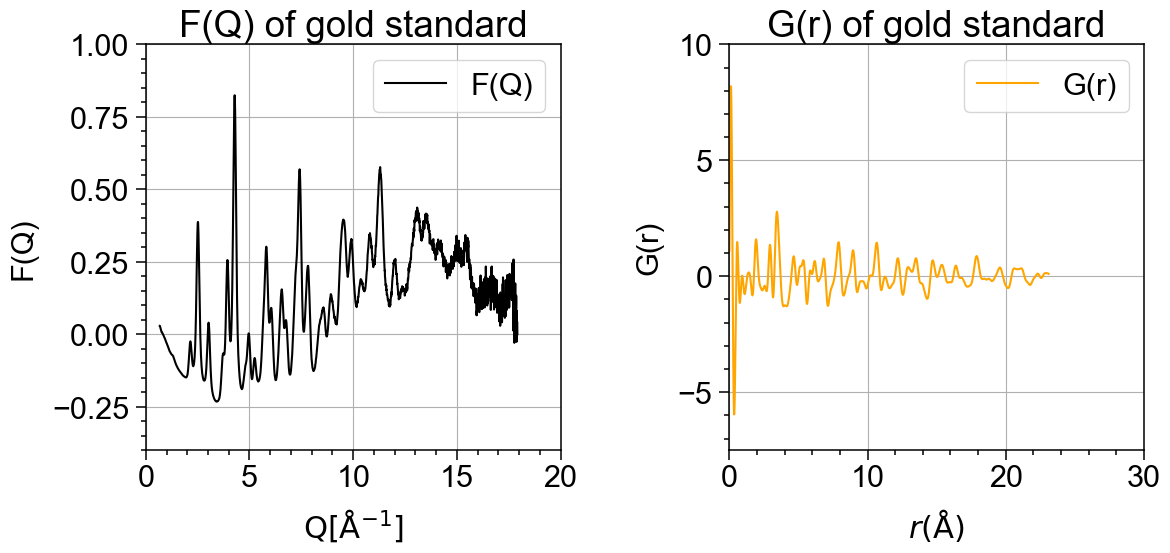

In [64]:
# First subplot for F(Q)
fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].plot(dp1.q, _fq, label='F(Q)')
axes[0].set_title('F(Q) of gold standard')
axes[0].set_xlabel(r'$\rm Q [\AA^{-1}]$')
axes[0].set_ylabel('F(Q)')
axes[0].legend()
axes[0].grid(True)

# Second subplot for G(r)
axes[1].plot(_r, _Gr, label='G(r)', color='orange')
axes[1].set_title('G(r) of gold standard')
axes[1].set_xlabel(r'$r(\rm\AA)$')
axes[1].set_ylabel('G(r)')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

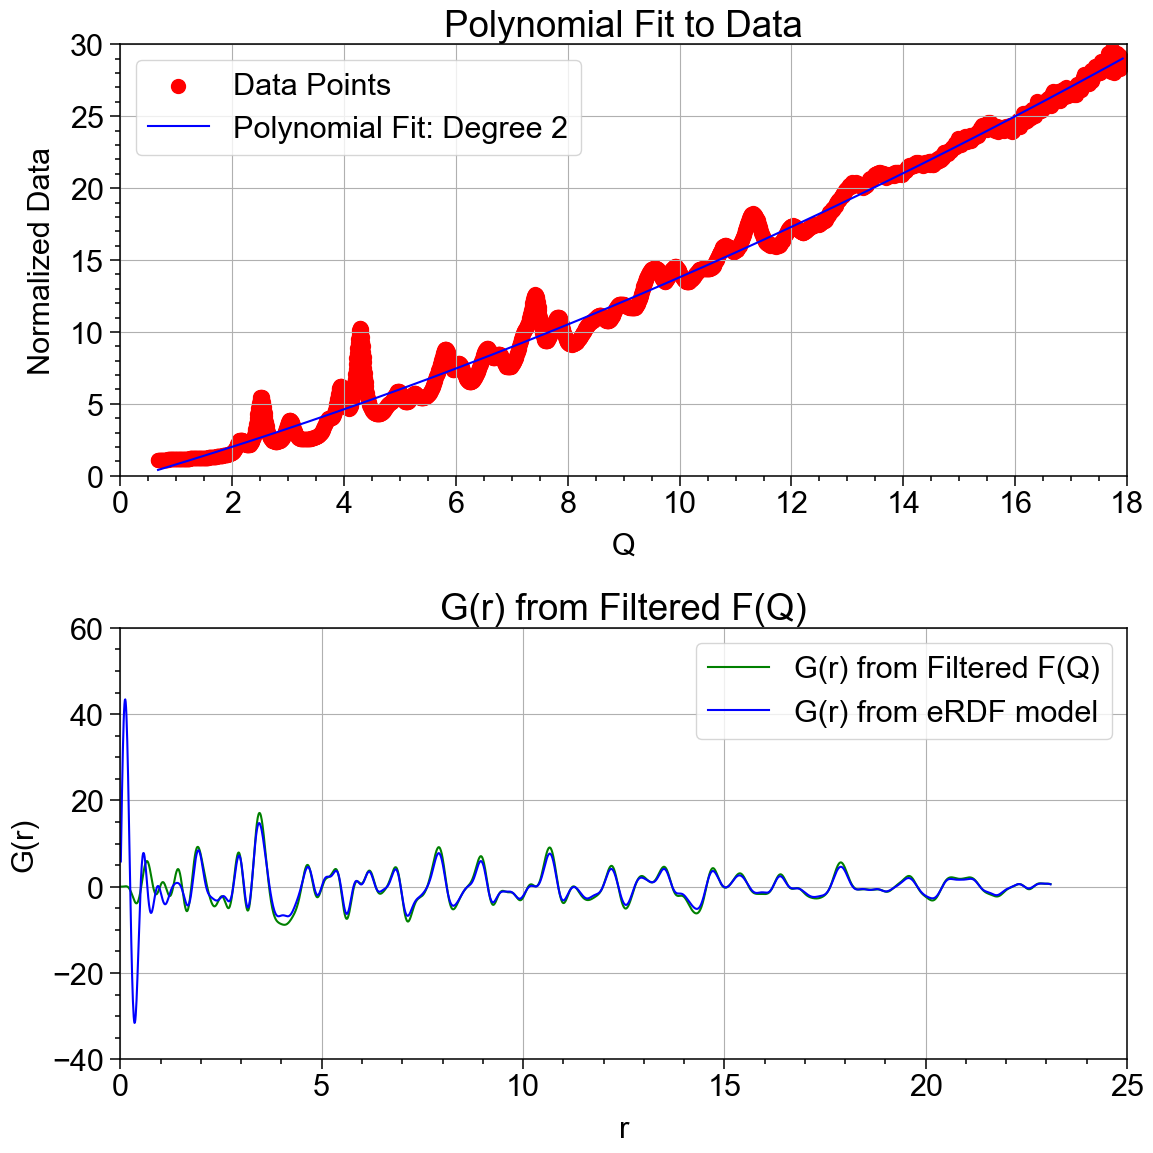

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define the butter_lowpass_filter function if not defined
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Normalize the data
norm_data = raw_data[start:end] / (dp1.N * dp1.fq_sq)
norm_data = norm_data * dp1.q

degree = 2
# Fit the polynomial
coefficients = np.polyfit(dp1.q, norm_data, degree)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial fit
x_fit = np.linspace(dp1.q.min(), dp1.q.max(), len(norm_data))
y_fit = polynomial(x_fit)

# Calculate _fq_poly and apply Butterworth lowpass filter
_fq_poly = norm_data - y_fit
_fq_poly = butter_lowpass_filter(_fq_poly, fs=20.0, cutoff=1.0, order=3)

# Calculate _Gr_Poly
_r, _Gr_Poly = dp1.calculate_Gr(_fq_poly, rmax=50, dr=0.01)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot polynomial fit to the data
axs[0].scatter(dp1.q, norm_data, color='red', label='Data Points')
axs[0].plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit: Degree {degree}')
axs[0].set_title('Polynomial Fit to Data')
axs[0].set_xlabel('Q')
axs[0].set_ylabel('Normalized Data')
axs[0].legend()
axs[0].grid(True)

# Plot G(r)
axs[1].plot(_r, _Gr_Poly, color='green', label='G(r) from Filtered F(Q)')
axs[1].plot(_r, _Gr*(5.3), color='blue', label='G(r) from eRDF model')
axs[1].set_title('G(r) from Filtered F(Q)')
axs[1].set_xlabel('r')
axs[1].set_ylabel('G(r)')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


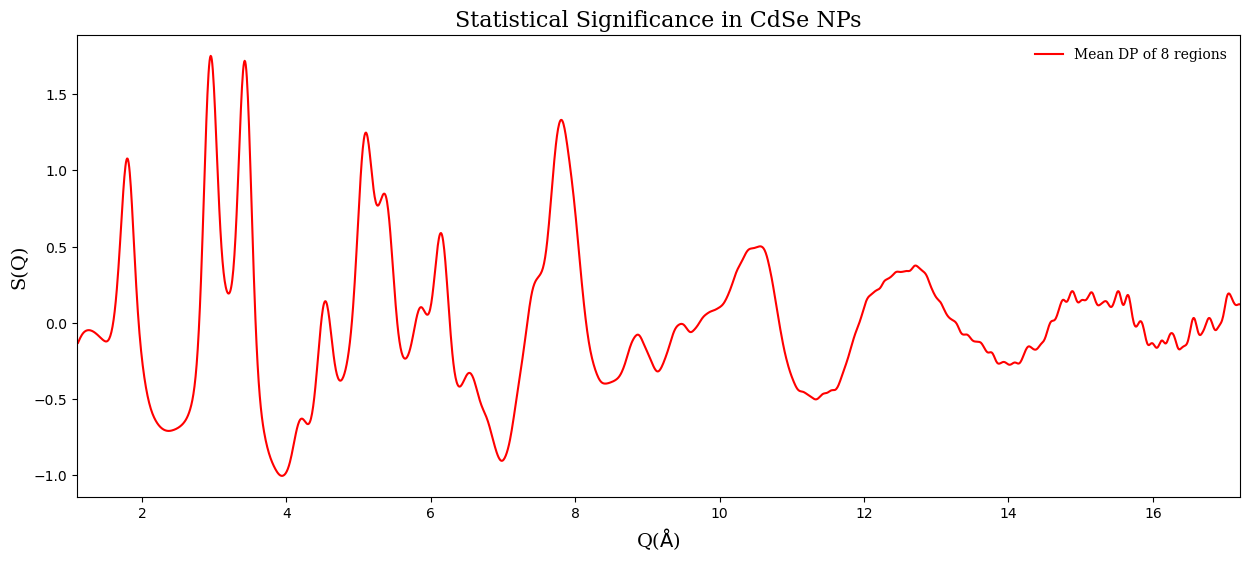

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(dp1.q, _fq_poly, color='red', label='Mean DP of 8 regions')
#plt.plot(dp1.q, fq_poly_indiv, color='black', label=r'Individual DP')
#plt.plot(dp1.q, _fq_poly, color='blue', label=r'Stacked DPs')
#plt.plot(dp1.q, norm_data-y_fit)

#diff_21 = np.array(_fq_poly) - np.array(fq_poly_indiv)
#diff_31 = np.array(_fq_poly) - np.array(fq_poly_mean)

#plt.plot(dp1.q, diff_21-1.5, color='blue', linestyle='--', label='Mean - Individual')
#plt.plot(dp1.q, diff_31-1.5, color='black', linestyle='--', label='Stack - Mean')
# Adding title and labels
plt.title('Statistical Significance in CdSe NPs', fontsize=16, fontname='serif')
plt.xlabel(r'Q($\rm\AA$)', fontsize=14, fontname='serif')
plt.ylabel('S(Q)', fontsize=14, fontname='serif')
plt.xlim(1.1, 17.2)

# Adding a legend
plt.legend(fontsize=14, prop={'family': 'serif'}, frameon=False)


# Display the plot
plt.show()

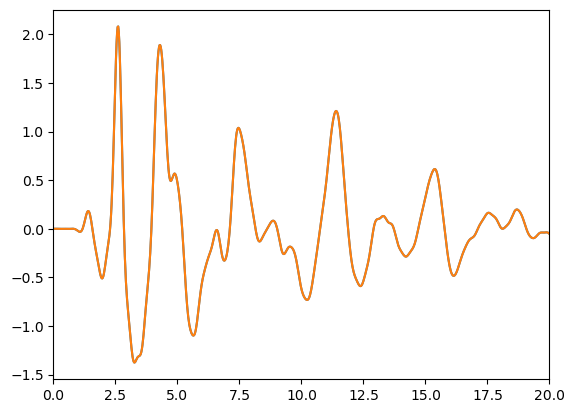

In [48]:

plt.plot(_r, _Gr_Poly)
plt.plot(_r, _Gr_Poly)
plt.xlim(0, 20)


data = pd.DataFrame(np.transpose(np.array((_r, _Gr_Poly))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(os.path.join(path, 'Gr_without_q.csv'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _fq_poly))))
#datasq.rename(columns={0:'q',1:'sq'}, inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq_normalized))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'ISq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')


In [175]:
# Specify the directory containing the CSV files
folder_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/CdSe_ePDF/L2_CdSe/Results'

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.startswith('Stacked')]

# Check to ensure exactly 8 CSV files are present
if len(csv_files) != 8:
    raise ValueError("There should be exactly 8 CSV files in the folder.")

# Initialize a list to store DataFrames
data_frames = []

# Process each file
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file)
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Add DataFrame to the list
    data_frames.append(df)

# Concatenate all DataFrames along the columns (axis=1) and compute the mean along the columns
resultant_mean = pd.concat(data_frames, axis=1).mean(axis=1)

# Save the mean values to a text file
with open(os.path.join(folder_path, 'average.csv'), 'w') as f:
    for mean in resultant_mean:
        f.write(f'{mean}\n')



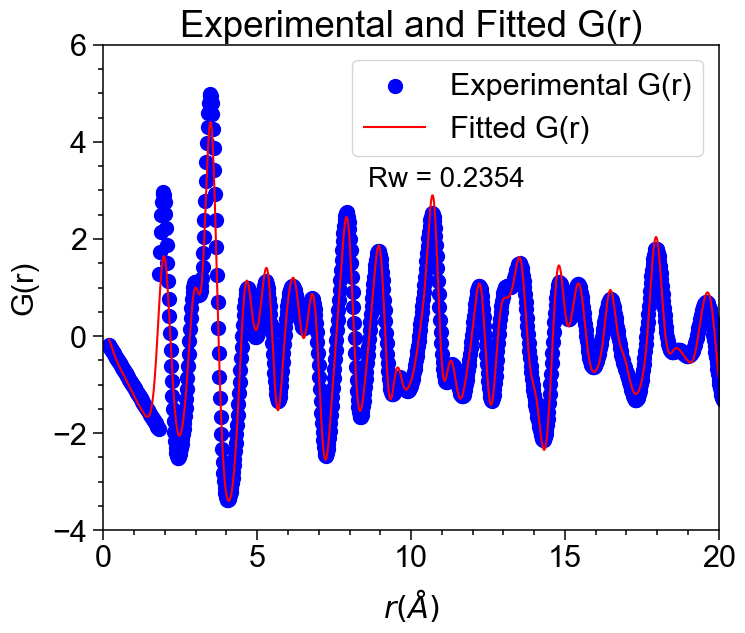

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from packages.eRDF import read_discus_fit_file, calculate_rw, optimize_constant

# Define the range of indices
index_range = slice(0, 2220)

path = "/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/"

df_exp = pd.read_csv(os.path.join(path, "Gr/Gr_Fe2O3_Oam.csv"), sep="\t", index_col="Unnamed: 0")
r_exp = df_exp['r'].values[index_range]
Gr_exp = df_exp['gr'].values[index_range]

# Read the fitted G(r) data
df_fit = read_discus_fit_file(os.path.join(path, "Fit/Gr_Fe2O3_Oam_Spc96_Oam_fit"))
r_fit = df_fit['r'].values[index_range]
Gr_fit = df_fit['gr'].values[index_range]

# Optimize the constant
optimized_constant = optimize_constant(Gr_exp, Gr_fit, initial_guess=0.1)

# Calculate Rw
rw_optimized = calculate_rw(Gr_exp, Gr_fit, optimized_constant)

# Plot the experimental and fitted G(r) values
plt.figure(figsize=(8, 6))
plt.scatter(r_exp, Gr_exp * optimized_constant, label='Experimental G(r)', color='blue')
plt.plot(r_fit, Gr_fit, label='Fitted G(r)', color='red')
plt.title('Experimental and Fitted G(r)')
plt.xlabel(r'$r (\AA)$')
plt.ylabel('G(r)')
plt.xlim(0, 20)
plt.legend()

# Add Rw as text in the plot
plt.text(0.43, 0.75, f'Rw = {rw_optimized:.4f}', transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')

# Show the plot
plt.show()


In [99]:
#Multiple ePDF data generation
combined_data = pd.DataFrame()


path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Corning/CAS70/Results/'
root_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Corning/CAS70/'
for file_name in os.listdir(path):
  if file_name.endswith('.csv'):
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(file_path, sep = '\t', header = None)
    df.rename(columns={0: file_name}, inplace=True)
    combined_data = pd.concat([combined_data, df], axis = 1)

gr_data = pd.DataFrame()
sq_data = pd.DataFrame()

for i in combined_data.columns:
  dp1 = DataProcessor(combined_data[i], lobato_path, start, end, ds, CAS70, region = 0)
  _iq = dp1.iq
  _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
  _r, _Gr = dp1.calculate_Gr_Lorch(_fq, rmax = 50, dr = math.pi/dp1.q.max(), a = 2.0, b = 0.5)
  _Gr, _ = dp1.low_r_correction(_Gr, nd, _r, r_cut = 1.2)
  _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq, nd)
  _Gr = pd.DataFrame(_Gr, columns = [i[:-4]], index = _r)
  gr_data= pd.concat([gr_data, _Gr], axis = 1)
  _fq = pd.DataFrame(_fq, columns = [i[:-4]], index = dp1.q)
  sq_data = pd.concat([sq_data, _fq], axis = 1)

sq_data.to_csv(os.path.join(path, 'Sq_CAS70.csv'), sep='\t',float_format="%.10f", index='r')

In [ ]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.007584086757763026/(2*math.pi) #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
CAS70 = {1: [14, 0.234], 2: [13, 0.0592], 3: [20, 0.0735], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}
Magnetite = {1: [26, 2], 2: [8, 3],}

#Si	Al	Ca	O
#CAS 40 0.134333333	0.1192	0.1495	0.596966667
#CAS 50 0.165333333	0.1004	0.1265	0.607766667
#CAS 60 0.201	0.0796	0.099	0.6204
#CAS 70 0.235	0.0592	0.0735	0.6323
#FS 0.333333333			0.666666667

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/'
file_name = 'Fe2O3_Oleyl.csv'

df = pd.read_csv(os.path.join(path, file_name), header = None)
                 #,decimal = ',')

data = df[0].values
start = int(data.shape[0]*0.05)
end =  int(data.shape[0]*0.8)
#ds = 3.6145889400000004/data.shape[0]

dp1 = DataProcessor(data, lobato_path, start, end, ds, Magnetite, region = 0)
 
_iq = dp1.iq
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
_fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
_r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
first_peak = np.where((_r > 1.6) & (_r < 2.5), _Gr, 0)
second_peak = np.where((_r > 2.5) & (_r < 4), _Gr, 0)
third_peak = np.where((_r > 4) & (_r < 7), _Gr, 0)
_Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.2, _r, r_cut = 1.7)



#_Gr2= _Gr*0.8

_gr = _Gr/(4 * math.pi * nd * _r)+1

_inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)
_inverse_fq1 = dp1.inverse_fourier_transform(first_peak, _r, _fq_filtered, nd)
_inverse_fq2 = dp1.inverse_fourier_transform(second_peak, _r, _fq_filtered, nd)
_inverse_fq3 = dp1.inverse_fourier_transform(third_peak, _r, _fq_filtered, nd)
#inverse_sq = (_inverse_fq/dp1.s)+1

print(dp1.N)


dp1.plot_results(_fq, _inverse_fq, _Gr, _r, _Gr, 0)

"""
data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
data.rename(columns={0:'r',1:'gr'},inplace=True)
data['dr']=data['r']*0
data['dgr']=abs(data['gr']/20)
data.to_csv(os.path.join(path, 'Gr_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')

datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
datasq.rename(columns={0:'q',1:'sq'},inplace=True)
datasq.to_csv(os.path.join(path, 'Sq_'f'{file_name}'), sep='\t',float_format="%.10f", index='r')
"""

In [61]:
#Optimizing scale factor minimizing Rw

path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/'

fit_path = os.path.join(path, 'Fit/Gr_Fe3O4_Oleyl_fit')
file_path = os.path.join(path, 'Gr/Gr_nocut_Fe3O4_Oleyl-OH.grobs')
from packages.eRDF import read_discus_fit_file, calculate_rw, optimize_constant


def remove_empty_strings(lst):
    return [element for element in lst if element != ""]
# Apply the function to each element in 'ListColumn'

calc = read_discus_fit_file(fit_path)

#data = read_discus_fit_file(file_path)

#data = pd.read_csv(file_path, sep = '\t')
#data = data.drop(columns='Unnamed: 0')
grobs = data['gr'].values[:2346]

# Assuming grobs and calc['gr'].values are defined elsewhere in your code
# For example:
# grobs = np.array([...])  # Your observed data
# calc = np.array([...])  # Your calculated data, equivalent to calc['gr'].values



# Usage
optimized_constant = optimize_constant(grobs, calc['gr'].values, initial_guess=0.1)
rw_optimized = calculate_rw(grobs, calc['gr'].values, optimized_constant)
print(f"Optimized constant: {optimized_constant}")
print(f"Optimized rw: {rw_optimized}")

#data.to_csv(file_path, sep =',')
#calc.to_csv(fit_path, sep = ',')

r = calc['r'].values
gr = calc['gr'].values
plt.figure(figsize=(12,3))
plt.scatter(data['r'].values[:2346], grobs*2.51665398, label = file_path[55:-4])
plt.plot(data['r'].values[:2346], gr, color = 'red', label = 'DISCUS Fit')
plt.legend()
plt.xlim(0,40)

Optimized constant: [2.68495534]
Optimized rw: 0.22311156837064108


In [ ]:
lobato_path = 'Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.00120486298 #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}


path = 'Binning/Results'
names = [x for x in os.listdir(path) if x.endswith('.csv')]

Grs = []
fqs = []
qs = []
_rs = []

for name in names:   
    df = pd.read_csv(os.path.join(path, name), sep = '\t', header = None)         
    start = int(df.shape[0]*0.05)
    end =  int(df.shape[0]*0.8333333333333334)
    ds = 3.6145889400000004/df.shape[0]
    dp1 = DataProcessor(df[0], lobato_path, start, end, ds, FS, region = 0.2)
    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
    _fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
    _r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
    _Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.65, _r, r_cut = 1)
    _gr = _Gr/(4 * math.pi * nd * _r)+1
    Grs.append(_Gr)
    fqs.append(_fq)
    _rs.append(_r)
    qs.append(dp1.q)
    _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)

f, ax = plt.subplots(2,1, figsize = (10,5))
for i in range(len(Grs)):
    ax[0].plot(qs[i], fqs[i], label = names[i][10:-4])
    #ax[0].set_xlim(11.5,13.5)
    #ax[0].set_ylim(0.2,0.7)
    ax[0].legend()
    ax[1].plot(_rs[i], Grs[i])
    ax[1].set_xlim(1,5)


plt.show()
#dp1.plot_results(_fq, _fq2, _Gr, _r, _Gr2, 0)


#data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
#data.rename(columns={0:'r',1:'gr'},inplace=True)
#data['dr']=data['r']*0
#data['dgr']=abs(data['gr']/20)
#data.to_csv(os.path.join(path, 'Gr_'f{file_path}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_path}'), sep='\t',float_format="%.10f", index='r')

In [ ]:
#Trying to implement hdf5 file format for organization
import h5py

file_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe3O4_classica/Fe3O4_classica.hdf5'
# Create a new HDF5 file
with h5py.File(file_path, 'w') as file:
    # This is where the magic will happen
    pass

metadata_dtype = np.dtype([
    ('Optimized_constant', 'f8'),  # 'f8' is for 64-bit floating-point number
    ('RW_optimized', 'f8'),
    ('Rvalue', 'f8'),
    ('P_lat', 'f8'),
    ('P_bval', 'f8'),
    ('P_diam_a', 'f8'),
    ('P_diam_b', 'f8'),
    ('P_diam_c', 'f8'),
    ('P_eta', 'f8'),
    ('P_u', 'f8'),
    ('P_v', 'f8'),
    ('P_w', 'f8'),
    ('P_scale', 'f8'),
    ('P_cover', 'f8')
])

metadata_array = metadata_array = np.array([(optimized_constant, rw_optimized,
    0.9896355948E+01,  # Rvalue
    0.8315070005E+01,  # P_lat
    0.1026873336E+01,  # P_bval
    0.3000340777E+02,  # P_diam_a
    0.3044978447E+02,  # P_diam_b
    0.3005941614E+02,  # P_diam_c
    0.9999944857E+00,  # P_eta
    0.0000000000E+00,  # P_u
    0.0000000000E+00,  # P_v
    0.1000000000E-03,  # P_w
    0.5232824800E+00,  # P_scale
    0.0000000000E+00   # P_cover
)], dtype=metadata_dtype)

with h5py.File(file_path, 'a') as file:
    # Create a group for a sample
    sample_group = file.create_group('Fe2O3_Oam')
    
    # Within this sample group, let's add some datasets
    # For example, storing the raw data, PDF, and metadata for the sample
    raw_data = sample_group.create_dataset('fit_data', data=calc.values)
    pdf_data = sample_group.create_dataset('grobs_data', data=data.values)
    metadata = sample_group.create_dataset('metadata', data=metadata_array)

    with h5py.File(file_path, 'r') as file:
    # Access the group for Sample_001
    sample_group = file['Fe3O4_classica']
    
    # Now you can access datasets within this group
    raw_data = sample_group['fit_data'][:]
    pdf_data = sample_group['grobs_data'][:]
    metadata = sample_group['metadata'][:]

    import h5py

def print_structure(filename, indent=''):
    """
    Prints the structure of the HDF5 file.
    """
    with h5py.File(filename, 'r') as file:
        def recurse(group, indent):
            for key in group.keys():
                item = group[key]
                print(indent + key)
                if isinstance(item, h5py.Dataset):
                    # Dataset; you could print dataset details here if desired
                    pass
                elif isinstance(item, h5py.Group):
                    # It's a group, so we recurse into it
                    recurse(item, indent + '  ')
        recurse(file, indent)

# Replace 'my_pdf_project.hdf5' with your actual file name
print_structure(file_path)

In [ ]:
f, ax = plt.subplots(4,2, figsize = (15, 8))

#ax[0].plot(dp1.q, _inverse_fq)
ax[0, 0].plot(dp1.q, _inverse_fq1)
#ax[0, 0].set_xlabel('Q (1/Angstrom)')

#ax[1].plot(_r, _Gr)
ax[0, 1].plot(_r, first_peak)
ax[0, 1].set_xlim(0,20)
#ax[0, 1].set_xlabel('r (Angstrom)')

ax[1, 0].plot(dp1.q, _inverse_fq2, color = 'orange')
#ax[1, 0].set_xlabel('Q (1/Angstrom)')

#ax[3].plot(_r, _Gr)
ax[1, 1].plot(_r, second_peak, color = 'orange')
ax[1, 1].set_xlim(0,20)
#ax[1, 1].set_xlabel('r (Angstrom)')

ax[2, 0].plot(dp1.q, _inverse_fq3, color = 'green')
#ax[2, 0].set_xlabel('Q (1/Angstrom)')

#ax[5].plot(_r, _Gr)
ax[2, 1].plot(_r, third_peak, color = 'green')
ax[2, 1].set_xlim(0,20)
#ax[2, 1].set_xlabel('r (Angstrom)')

ax[3, 0].plot(dp1.q, _inverse_fq, color = 'red')
ax[3, 0].set_xlabel('Q ($\mathrm{\AA}^{-1}$)', fontsize = 15)

#ax[7].plot(_r, _Gr)
ax[3, 1].plot(_r, _Gr, color = 'red')
ax[3, 1].set_xlim(0,20)
ax[3, 1].set_xlabel('r ($\mathrm{\AA}$)', fontsize = 15)


plt.show()

In [273]:
path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Results/'

fit_path = os.path.join(path, 'Fit/Gr_Fe2O3_Oam_Spc96_Oam_fit')
file_path = os.path.join(path, 'Gr/Gr_Fe2O3_Oam.csv')
from packages.eRDF import read_discus_fit_file, calculate_rw


def remove_empty_strings(lst):
    return [element for element in lst if element != ""]
# Apply the function to each element in 'ListColumn'

calc = read_discus_fit_file(fit_path)
data = pd.read_csv(file_path, sep = '\t')

#data = pd.read_csv(file_path, sep = '\t')
#data = data.drop(columns='Unnamed: 0')
grobs = data['gr'].values[:2348]


In [274]:

optimized_constant = optimize_constant(grobs, calc['gr'].values)
rw_optimized = calculate_rw(grobs, calc['gr'].values, optimized_constant)
print(f"Optimized constant: {optimized_constant}")
print(f"Optimized rw: {rw_optimized}")

Optimized constant: [2.11363343]
Optimized rw: 0.23552357972388846


(0.0, 50.0)

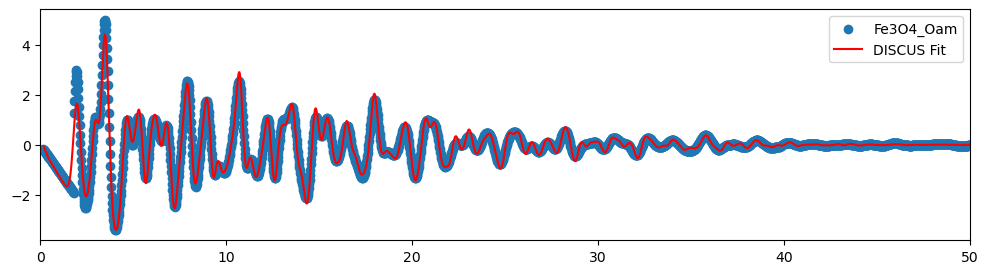

In [276]:
#data.to_csv(file_path, sep =',')
#calc.to_csv(fit_path, sep = ',')

r = calc['r'].values
gr = calc['gr'].values
plt.figure(figsize=(12,3))
plt.scatter(data['r'].values[:2348], grobs*optimized_constant, label = 'Fe3O4_Oam')
plt.plot(r, gr, color = 'red', label = 'DISCUS Fit')
plt.legend()
plt.xlim(0,50)

In [ ]:
lobato_path = 'Lobato_2014.txt'

#ds = 0.00139501338 #Fe3O4-Oleyl
#ds = 0.001147 #AuNPs
ds = 0.00120486298 #AuNPs
#ds = 0.00096525376 #Fe3O4-Oam
nd = 0.08673


CAS40 = {1: [14, 0.1343], 2: [13, 0.1192], 3: [20, 0.1495], 4: [20, 0.59696],}
CAS50 = {1: [14, 0.1653], 2: [13, 0.1004], 3: [20, 0.1265], 4: [8, 0.6204],}
CAS60 = {1: [14, 0.201], 2: [13, 0.0796], 3: [20, 0.099], 4: [8, 0.6323],}
FS = {1: [14, 0.33], 2: [13, 0.0], 3: [20, 0.0], 4: [8, 0.66],}


path = 'Binning/Results'
names = [x for x in os.listdir(path) if x.endswith('.csv')]

Grs = []
fqs = []
qs = []
_rs = []

for name in names:   
    df = pd.read_csv(os.path.join(path, name), sep = '\t', header = None)         
    start = int(df.shape[0]*0.05)
    end =  int(df.shape[0]*0.8333333333333334)
    ds = 3.6145889400000004/df.shape[0]
    dp1 = DataProcessor(df[0], lobato_path, start, end, ds, FS, region = 0.2)
    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0.2)
    _fq_filtered = butter_lowpass_filter(_fq, fs = 30.0, cutoff = 2.0, order = 3)
    _r, _Gr = dp1.calculate_Gr_Lorch(_fq_filtered, rmax = 50, dr = math.pi/dp1.q.max(), a = 1.6, b = 0.5)
    _Gr, _Gr_low_r = dp1.low_r_correction(_Gr, nd*0.65, _r, r_cut = 1)
    _gr = _Gr/(4 * math.pi * nd * _r)+1
    Grs.append(_Gr)
    fqs.append(_fq)
    _rs.append(_r)
    qs.append(dp1.q)
    _inverse_fq = dp1.inverse_fourier_transform(_Gr, _r, _fq_filtered, nd)

f, ax = plt.subplots(2,1, figsize = (10,5))
for i in range(len(Grs)):
    ax[0].plot(qs[i], fqs[i], label = names[i][10:-4])
    #ax[0].set_xlim(11.5,13.5)
    #ax[0].set_ylim(0.2,0.7)
    ax[0].legend()
    ax[1].plot(_rs[i], Grs[i])
    ax[1].set_xlim(1,5)


plt.show()
#dp1.plot_results(_fq, _fq2, _Gr, _r, _Gr2, 0)


#data = pd.DataFrame(np.transpose(np.array((_r, _Gr))))
#data.rename(columns={0:'r',1:'gr'},inplace=True)
#data['dr']=data['r']*0
#data['dgr']=abs(data['gr']/20)
#data.to_csv(os.path.join(path, 'Gr_'f{file_path}'), sep='\t',float_format="%.10f", index='r')

#datasq = pd.DataFrame(np.transpose(np.array((dp1.q, _inverse_fq))))
#datasq.rename(columns={0:'q',1:'sq'},inplace=True)
#datasq.to_csv(os.path.join(path, 'Sq_'f'{file_path}'), sep='\t',float_format="%.10f", index='r')

In [ ]:
#Trying to implement hdf5 file format for organization
import h5py

file_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe3O4_classica/Fe3O4_classica.hdf5'
# Create a new HDF5 file
with h5py.File(file_path, 'w') as file:
    # This is where the magic will happen
    pass

metadata_dtype = np.dtype([
    ('Optimized_constant', 'f8'),  # 'f8' is for 64-bit floating-point number
    ('RW_optimized', 'f8'),
    ('Rvalue', 'f8'),
    ('P_lat', 'f8'),
    ('P_bval', 'f8'),
    ('P_diam_a', 'f8'),
    ('P_diam_b', 'f8'),
    ('P_diam_c', 'f8'),
    ('P_eta', 'f8'),
    ('P_u', 'f8'),
    ('P_v', 'f8'),
    ('P_w', 'f8'),
    ('P_scale', 'f8'),
    ('P_cover', 'f8')
])

metadata_array = metadata_array = np.array([(optimized_constant, rw_optimized,
    0.9896355948E+01,  # Rvalue
    0.8315070005E+01,  # P_lat
    0.1026873336E+01,  # P_bval
    0.3000340777E+02,  # P_diam_a
    0.3044978447E+02,  # P_diam_b
    0.3005941614E+02,  # P_diam_c
    0.9999944857E+00,  # P_eta
    0.0000000000E+00,  # P_u
    0.0000000000E+00,  # P_v
    0.1000000000E-03,  # P_w
    0.5232824800E+00,  # P_scale
    0.0000000000E+00   # P_cover
)], dtype=metadata_dtype)

with h5py.File(file_path, 'a') as file:
    # Create a group for a sample
    sample_group = file.create_group('Fe2O3_Oam')
    
    # Within this sample group, let's add some datasets
    # For example, storing the raw data, PDF, and metadata for the sample
    raw_data = sample_group.create_dataset('fit_data', data=calc.values)
    pdf_data = sample_group.create_dataset('grobs_data', data=data.values)
    metadata = sample_group.create_dataset('metadata', data=metadata_array)

    with h5py.File(file_path, 'r') as file:
    # Access the group for Sample_001
    sample_group = file['Fe3O4_classica']
    
    # Now you can access datasets within this group
    raw_data = sample_group['fit_data'][:]
    pdf_data = sample_group['grobs_data'][:]
    metadata = sample_group['metadata'][:]

    import h5py

def print_structure(filename, indent=''):
    """
    Prints the structure of the HDF5 file.
    """
    with h5py.File(filename, 'r') as file:
        def recurse(group, indent):
            for key in group.keys():
                item = group[key]
                print(indent + key)
                if isinstance(item, h5py.Dataset):
                    # Dataset; you could print dataset details here if desired
                    pass
                elif isinstance(item, h5py.Group):
                    # It's a group, so we recurse into it
                    recurse(item, indent + '  ')
        recurse(file, indent)

# Replace 'my_pdf_project.hdf5' with your actual file name
print_structure(file_path)